In [30]:
import torch
x = torch.rand(5, 3)
print(x)
torch.cuda.is_initialized()

tensor([[0.8474, 0.6293, 0.7963],
        [0.5737, 0.7529, 0.8316],
        [0.0579, 0.4212, 0.4250],
        [0.4723, 0.3578, 0.2348],
        [0.7981, 0.4248, 0.0284]])


False

In [14]:
def f(x): return (x+1)*(x-1)*(x+2)*(x-2)


h = 1e-5  # 一个非常小的数字
x = 1
(f(x+h)-f(x-h))/(2*h)

-5.999999999606

In [17]:
def eval_numerical_gradient(function, input, h=1e-5):
    assert type(input) == np.ndarray, '输入应为一个矩阵'
    # 保存输入数据的维度，梯度应和待求梯度的变量维度一致
    shape = input.shape
    # 将输入数据展开，以方便计算
    data = np.ravel(input)
    # 初始化，保存梯度
    gradient = np.zeros_like(data, dtype=float)
    # 按公式计算每一个变量的梯度
    for index in range(data.shape[0]):
        # 公式 1 实现
        data[index] += h
        value1 = function(data.reshape(shape))
        data[index] -= 2*h
        value2 = function(data.reshape(shape))
        
        # 计算梯度
        gradient[index] = (value1-value2)/(2*h)
        
        # 将该变量变回最初的
        data[index] += h
        
    # 返回梯度时，需要 reshape 为原始输入数据的维度
    return np.reshape(gradient, shape)

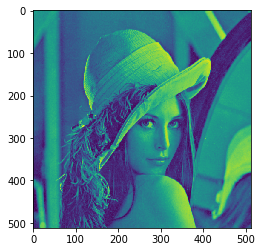

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 读取图片并转化为灰度图
img = cv2.imread('lena.png', )
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(img)


[510 510]


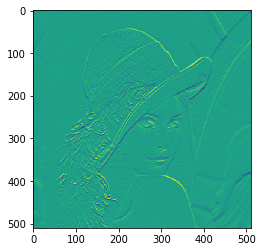

In [14]:
# 上面定义的卷积核
kernel = np.array([[-1, 0, 1], 
                   [-2, 0, 2], 
                   [-1, 0, 1]])
kernel1 = np.array([[-1, -2, -1], 
                   [0, 0, 0], 
                   [1, 2, 1]])
# 对原图做卷积
kernel_size, stride, padding = 3, 1, 0
# 计算输出大小
output_shape = (
    np.floor((np.array(img.shape)-kernel_size)/stride)+1).astype(int)
output = np.zeros(output_shape)
output1 = np.zeros(output_shape)
print(output_shape)
# 遍历输出图片，输出图片的数据等于卷积核对输入图片相应位置卷积
for rows in range(output_shape[0]):
    for coloumns in range(output_shape[1]):
        output[rows, coloumns] = np.sum(
            kernel*img[rows*stride: rows*stride+kernel_size, 
                       coloumns*stride: coloumns*stride+kernel_size])
for rows in range(output_shape[0]):
    for coloumns in range(output_shape[1]):
        output1[rows, coloumns] = np.sum(
            kernel1*img[rows*stride: rows*stride+kernel_size, 
                       coloumns*stride: coloumns*stride+kernel_size])
#plt.imshow(output)
plt.imshow(output1)

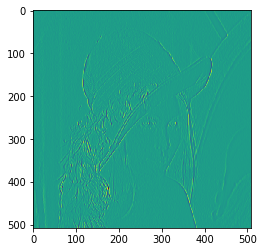

In [5]:
# 上面定义的卷积核
kernel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
# 对原图做卷积
kernel_size, stride, padding = 3, 1, 0
# 计算输出大小
output_shape = (
    np.floor((np.array(output.shape)-kernel_size)/stride)+1).astype(int)
output2 = np.zeros(output_shape)
# 遍历输出图片，输出图片的数据等于卷积核对输入图片相应位置卷积
for rows in range(output_shape[0]):
    for coloumns in range(output_shape[1]):
        output2[rows, coloumns] = np.sum(
            kernel*output[rows*stride: rows*stride+kernel_size, 
                       coloumns*stride: coloumns*stride+kernel_size])
plt.imshow(output2)

In [15]:
class conv2d(object):
    '''
    output_channel: 该层卷积核的数量
    input_channel: 输入数据的通道数，例如灰度图为1，彩色图为3，又或者上一层的卷积数量为12，那下一层卷积的输入通道为12
    kernel_size: 卷积核大小
    stride: 卷积移动的步长
    padding: 补齐
    '''

    def __init__(self, input_channel, output_channel, kernel_size, stride=1, padding=0):
        # 初始化网络权重，卷积核数量*输入通道数*卷积核大小*卷积核大小
        # 一个卷积核应为输入通道数*卷积核大小*卷积核大小，每一层有多个卷积核
        self.weight = (np.random.randn(output_channel, input_channel,
                                       kernel_size, kernel_size)*0.01).astype(np.float32)
        # 偏置项，每一个卷积核都对应一个偏置项，y=xW+b
        self.bias = np.zeros((output_channel), dtype=np.float32)
        # 保存各项参数
        self.output_channel = output_channel
        self.input_channel = input_channel
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

    def forward(self, input):
        # 输入数据各个维度代表的含义: batch_size, input_channel, height, width
        batch_size, input_channel, height, width = input.shape
        # 防止一些错误的调用
        assert len(input.shape) == 4, '输入必须是四维的，batch_size*channel*width*height'
        # 上一层的卷积核数量必须等于这一层的输入通道数
        assert input_channel == self.input_channel, '网络输入通道数必须与网络定义的一致'

        # 根据公式计算 Feature map 的大小
        feature_height = int(
            (height-self.kernel_size+2*self.padding)/self.stride)+1
        feature_width = int(
            (width-self.kernel_size+2*self.padding)/self.stride)+1
        # 对输入数据进行补齐
        input = np.pad(input, [(0, ), (0, ), (self.padding, ),
                               (self.padding, )], 'constant', constant_values=0)

        # 保存输入数据，后续需要计算梯度
        self.data = input

        # 初始化 Feature map
        feature_maps = np.zeros(
            (batch_size, self.output_channel, feature_height, feature_width), dtype=np.float32)

        # 再看一下 Lena 图片进行卷积操作的例子，这里为了为了计算高效只使用了两层循环，可以多层循环展开计算
        for i in range(feature_height):
            for j in range(feature_width):
                feature_maps[:, :, i, j] = np.sum(self.weight[np.newaxis, :, :, :, :]
                                                  *input[:, 
                                                         np.newaxis, 
                                                         :, 
                                                         i*self.stride: i*self.stride +self.kernel_size, 
                                                         j*self.stride: j*self.stride+self.kernel_size]
                                                  , axis=(2, 3, 4)) + self.bias[np.newaxis, :]
        return feature_maps

    '''
    top_grad: 上一层的梯度，维度为 batch_size, output_channel, feature_height, feature_width，与该层输出一致
    '''

    def backward(self, top_grad, lr):
        # 初始化梯度矩阵，维度和待求解梯度的数据一致
        self.grad = np.zeros_like(self.data, dtype=np.float32)
        self.grad_w = np.zeros_like(self.weight, dtype=np.float32)
        self.grad_b = np.zeros_like(self.bias, dtype=np.float32)

        # 上一层梯度的维度
        batch_size, output_channel, feature_height, feature_width = top_grad.shape

        # 遍历输出 Feature map 的每一个点
        for i in range(feature_height):
            for j in range(feature_width):
                for f in range(output_channel):
                    # 权重的梯度为对应数据乘以对应的输出数据的某个点的梯度，batch_size 直接求和即可
                    # 公式 12 实现
                    self.grad_w[f, :, :, :] += np.sum(np.multiply(self.data[:, :, i*self.stride: i*self.stride+self.kernel_size,
                                                                            j * self.stride: j*self.stride+self.kernel_size], 
                                                                  top_grad[:, f, i, j, np.newaxis, np.newaxis, np.newaxis]), axis=0)
                    # 对输入数据求梯度
                    for n in range(batch_size):
                        # 对应权重乘以上一层的对应点的梯度
                        # 公式 13 实现
                        self.grad[n, :, i*self.stride: i*self.stride+self.kernel_size, j*self.stride: j *
                                  self.stride+self.kernel_size] += top_grad[n, f, i, j]*self.weight[f]

        # 去除 padding 的影响
        self.grad = self.grad[:, :, self.padding: self.grad.shape[2] -
                              self.padding, self.padding: self.grad.shape[3]-self.padding]

        # 计算该层关于偏置的梯度
        # 直接对该卷积对应的 Feature map 的梯度求和即可
        # 公式 11 实现
        for i in range(self.output_channel):
            self.grad_b[i] = np.sum(top_grad[:, i, :, :])

        # 更新参数
        self.weight -= lr*self.grad_w
        self.bias -= lr*self.grad_b

In [101]:
A=np.arange(0,30).reshape(2,5,3)
print("A=",A)
B=np.zeros(A.shape[1])
for i in range(A.shape[1]):
    B[i] = np.sum(A[:, i, :])
print("B=",B)

A= [[[ 0  1  2]
  [ 3  4  5]
  [ 6  7  8]
  [ 9 10 11]
  [12 13 14]]

 [[15 16 17]
  [18 19 20]
  [21 22 23]
  [24 25 26]
  [27 28 29]]]
B= [ 51.  69.  87. 105. 123.]


In [16]:
import torch

# 定义各项参数
input_channel, output_channel, kernel_size, stride = 3, 10, 3, 1
# 定义一个这里实现的卷积层
conv = conv2d(input_channel, output_channel, kernel_size, stride)

# 输入数据
input = np.random.randn(2, input_channel, 28, 28).astype(np.float32)

# 同样的参数使用 PyTorch 的实现
conv_torch = torch.nn.Conv2d(
    input_channel, output_channel, kernel_size, stride)
# PyTorch 的实现对数据卷积
featuremaps_torch = conv_torch(torch.from_numpy(input))
# 加载 PyTorch 实现的卷积层权重和偏置到这里实现的卷积层之中
conv.weight = list(conv_torch.parameters())[0].detach().numpy()
conv.bias = list(conv_torch.parameters())[1].detach().numpy()
# 前向传播
featuremaps = conv.forward(input)
# 计算绝对值平均误差
np.mean(np.abs(featuremaps_torch.detach().numpy()-featuremaps))

4.762996e-08

In [64]:
# 梯度检测
# 定义各项参数
batch_size, input_channel, output_channel, kernel_size, stride, input_size = 1, 1, 2, 3, 2, 5
conv = conv2d(input_channel, output_channel, kernel_size, stride)
input = np.random.randn(batch_size, input_channel,
                        input_size, input_size).astype(np.float32)

# 保证每次测试时的参数是一致的
def init():
    np.random.seed(1)
    conv.weight = np.random.random(conv.weight.shape)*0.01
    conv.bias = np.zeros_like(conv.bias)

def check_weight_gradient(cur_weight):
    conv.weight = cur_weight
    # 损失函数为直接求和
    return np.sum(conv.forward(input))

def check_bias_gradient(cur_bias):
    conv.bias = cur_bias
    return np.sum(conv.forward(input))

def check_input_gradient(cur_input):
    return np.sum(conv.forward(cur_input))

In [65]:
init()
# 根据这里实现的计算三个梯度
feature_maps = conv.forward(input)
# 求和函数的梯度为全为 1 的矩阵
conv.backward(np.ones_like(feature_maps), lr=0.001)
analytic_gradient_w = conv.grad_w
analytic_gradient_b = conv.grad_b
analytic_gradient_input = conv.grad

# 因为上面 backward 时更新了参数
init()

# 计算权重的误差
numerical_gradient_w = eval_numerical_gradient(check_weight_gradient, conv.weight)
# 计算平均误差
weight_error = np.mean(np.abs(numerical_gradient_w-analytic_gradient_w))

init()
# 计算偏置的误差
numerical_gradient_b = eval_numerical_gradient(check_bias_gradient, conv.bias)
bias_error = np.mean(np.abs(numerical_gradient_b-analytic_gradient_b))

init()
# 计算输入的误差
numerical_gradient_input = eval_numerical_gradient(check_input_gradient, input)
input_error = np.mean(np.abs(numerical_gradient_input-analytic_gradient_input))

weight_error, bias_error, input_error

(8.267495367261636e-05, 0.00015580654144331518, 7.371102459728707e-05)

In [63]:
numerical_gradient_w, analytic_gradient_w

(array([[[[-1.15893781, -0.21858141, -1.02734193],
          [ 0.8424744 ,  0.42682514,  1.84699893],
          [-0.89071691,  0.0516884 , -1.02380291]]],
 
 
        [[[-1.15893781, -0.21848828, -1.02734193],
          [ 0.8424744 ,  0.426732  ,  1.84699893],
          [-0.89053065,  0.05159527, -1.02389604]]]]),
 array([[[[-2.3178272 , -0.43713355, -2.0547693 ],
          [ 1.6850107 ,  0.8535662 ,  3.6939182 ],
          [-1.7813416 ,  0.10323319, -2.0477629 ]]],
 
 
        [[[-2.3178272 , -0.43713355, -2.0547693 ],
          [ 1.6850107 ,  0.8535662 ,  3.6939182 ],
          [-1.7813416 ,  0.10323319, -2.0477629 ]]]], dtype=float32))

In [66]:
class MaxPool2d(object):

    # 各项参数
    def __init__(self, kernel_size, stride, padding=0):
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

    # 前向传播
    def forward(self, input):
        # input: batch_size, input channel, height, width
        assert len(input.shape) == 4, '输入必须是四维的，batch_size*channel*width*height'
        batch_size, input_channel, height, width = input.shape

        # 计算输出的大小，和卷积层一样
        feature_height = int(
            (height-self.kernel_size+2*self.padding)/self.stride)+1
        feature_width = int(
            (width-self.kernel_size+2*self.padding)/self.stride)+1
        # 初始化输出矩阵
        pooled_feature_map = np.zeros(
            (batch_size, input_channel, feature_height, feature_width))
        # 按设置的 padding 补齐
        input = np.pad(input, [(0, ), (0, ), (self.padding, ),
                               (self.padding, )], 'constant', constant_values=0)
        self.data = input
        # 窗口滑动
        for i in range(feature_height):
            for j in range(feature_width):
                # 最大池化
                pooled_feature_map[:, :, i, j] = np.max(
                    input[:, :, i*self.stride: i*self.stride+self.kernel_size,
                          j*self.stride: j*self.stride+self.kernel_size], axis=(2, 3))
        return pooled_feature_map

    # 后向传播
    def backward(self, top_grad):
        # 输入数据梯度
        self.grad = np.zeros_like(self.data)
        # 上一层梯度的维度
        batch_size, output_channel, feature_height, feature_width = top_grad.shape

        # 遍历输出 Feature map 的每一个点
        for n in range(batch_size):
            for i in range(feature_height):
                for j in range(feature_width):
                    # 取出这一块的数据
                    one_kernel_data = self.data[n, :, i*self.stride: i*self.stride +
                                                self.kernel_size,
                                                j*self.stride: j*self.stride+self.kernel_size]
                    # 下面三行代码都是获得最大值点的坐标
                    # 将一个矩形展开
                    channels = one_kernel_data.shape[0]
                    one_kernel_data = np.reshape(
                        one_kernel_data, (one_kernel_data.shape[0], -1))
                    # 获取该矩形最大值所在的坐标
                    one_kernel_featuremap_argmax = np.argmax(
                        one_kernel_data, axis=1)
                    # np.unravel_index 将被展开的坐标换算成对应的矩形内的坐标
                    argmax1, argmax2 = np.unravel_index(
                        one_kernel_featuremap_argmax, (self.kernel_size, self.kernel_size))
                    # 误差将会被分散到最大值所在的点上
                    # 公式 16 实现
                    self.grad[n, :, i*self.stride: i*self.stride+self.kernel_size, j*self.stride: j *
                              self.stride+self.kernel_size][np.arange(channels), 
                                                            argmax1, argmax2] += top_grad[n, :, i, j]

        # 去除 padding 的影响
        self.grad = self.grad[:, :, self.padding: self.grad.shape[2] -
                              self.padding, self.padding: self.grad.shape[3]-self.padding]

In [74]:
# 定义各项参数
batch_size, input_channel, kernel_size, stride, padding, input_height, input_width = 1,2,2,1,1,10,10

input = np.random.randn(batch_size, input_channel,
                        input_height, input_width).astype(np.float32)
pooling_layer = MaxPool2d(kernel_size, stride, padding=padding)
output = pooling_layer.forward(input)

pooling_layer.backward(np.ones_like(output))
analytic_gradient = pooling_layer.grad

In [102]:
def check_input_gradient(cur_input):
    return np.sum(pooling_layer.forward(cur_input))

# 计算输入的误差
numerical_gradient = eval_numerical_gradient(check_input_gradient, input)
input_error = np.mean(np.abs(numerical_gradient_input-analytic_gradient_input))

input_error

7.371102459728707e-05

In [103]:
class LeNet(object):
    def __init__(self):
        
        # 根据参数定义 LeNet-5 的各个组件
        self.conv1 = conv2d(1, 20, 5, 1)
        self.relu1 = ReLU()
        self.pool1 = MaxPool2d(2, 2)
        self.conv2 = conv2d(20, 50, 5, 1)
        self.relu2 = ReLU()
        self.pool2 = MaxPool2d(2, 2)
        self.fc1 = Linear(800, 500)
        self.relu3 = ReLU()
        self.fc2 = Linear(500, 10)

    # 前向传播过程
    def forward(self, input):
        # 根据网络结构定义前向传播，上一层的输出作为下一层的输入
        input = self.relu1.forward(self.conv1.forward(input))
        input = self.pool1.forward(input)
        input = self.relu2.forward(self.conv2.forward(input))
        input = self.pool2.forward(input)
        # 从池化或卷积到线性层数据必须展开称为向量，因为线性层只接受向量输入（对于单个样本）。
        # 在某些深度学习框架中，这个操作被封装为 FlattenLayer，本次课程不实现
        self.flatten_shape = input.shape  # 展开
        input = np.reshape(input, (input.shape[0], -1))
        input = self.relu3.forward(self.fc1.forward(input))
        output = self.fc2.forward(input)
        return output

    # 后向传播
    def backward(self, top_grad, lr):
        # 后向传播的顺序和前向传播相反
        self.fc2.backward(top_grad, lr)
        self.relu3.backward(self.fc2.grad)
        self.fc1.backward(self.relu3.grad, lr)
        # 被展开的梯度必须还原为上一层的维度
        unflattened_grad = np.reshape(self.fc1.grad, self.flatten_shape)
        self.pool2.backward(unflattened_grad)
        self.relu2.backward(self.pool2.grad)
        self.conv2.backward(self.relu2.grad, lr)
        self.pool1.backward(self.conv2.grad)
        self.relu1.backward(self.pool1.grad)
        self.conv1.backward(self.relu1.grad, lr)

In [6]:
from sklearn.preprocessing import OneHotEncoder
import nn
import numpy as np

# 读取并归一化数据，不归一化会导致 nan
test_data = ((nn.read_mnist('mnist/t10k-images.idx3-ubyte')) /
             256.0).astype(np.float32)[:, np.newaxis, :, :]
train_data = ((nn.read_mnist('mnist/train-images.idx3-ubyte')) /
              256.0).astype(np.float32)[:, np.newaxis, :, :]
# 独热编码标签
encoder = OneHotEncoder(categories='auto')
encoder.fit(np.arange(10).reshape((-1, 1)))
train_labels = encoder.transform(nn.read_mnist(
    'mnist/train-labels.idx1-ubyte').reshape((-1, 1))).toarray().astype(np.float32)
test_labels = encoder.transform(nn.read_mnist(
    'mnist/t10k-labels.idx1-ubyte').reshape((-1, 1))).toarray().astype(np.float32)

batch_size = 120
train_dataloader = nn.Dataloader(
    train_data, train_labels, batch_size, shuffle=True)
test_dataloader = nn.Dataloader(
    test_data, test_labels, batch_size, shuffle=False)


loss_layer = nn.CrossEntropyLossLayer()  # 损失层
lr = 0.1  # 学习率
np.random.seed(1)  # 固定随机生成的权重
max_iter = 6 # 最大迭代次数和步长
step_size = 4
scheduler = nn.lr_scheduler(lr, step_size)  # 学习率衰减

net = nn.LeNet()
#net = nn.Cifar10Net()
test_loss_list, train_loss_list, train_acc_list, test_acc_list, best_net = nn.train_and_test(
    loss_layer, net, scheduler, max_iter, train_dataloader, test_dataloader, batch_size)

AssertionError: 网络输入通道数必须与网络定义的一致

In [1]:
import torch

print(torch.__version__)

cuda = torch.cuda.is_available()
print(cuda)

a = torch.Tensor((3, 5))
print(a)
#print(a.cuda())

1.8.0+cpu
False
tensor([3., 5.])
